In [22]:
import sys
sys.path.append('/home/aurimas/coding/price-volume-mix/resources')
sys.path.append('/home/aurimas/coding/price-volume-mix/package')

In [23]:
from datasets.olist import sales_data

In [24]:

import polars as pl
import polars.selectors as cs
import tabulate
import numpy as np
import altair as alt
import importlib as imp
import itertools as itt

In [26]:
import pvm
import pvm.fields as pvmf
import pvm.calculations as pvmc
import pvm.charts as pmv_charts

imp.reload(pvmf)
imp.reload(pvmc)
pass

# Price-volume-mix analysis: 101 (with Python)

## What's price-volume-mix analysis?

If you ask a data analyst or data scientist about price-volume-mix analysis (also known as: "variance analysis", "sales/margin bridges" and a bunch of other names), you'll likely get a blank stare. It's not something that's taught in analytics curriculum, despite being a standard approach to analyze trends in data in finance and accounting teams (and likely shows up in MBA curriculums). I think that's kind of a shame - analytics teams often encounter situations where they need to "explain a change" in a metric that's simultaneously affected by number of components, and PVM analysis is a great tool for that. It's also behind fancy waterfall charts you may see in consulting reports like this one:

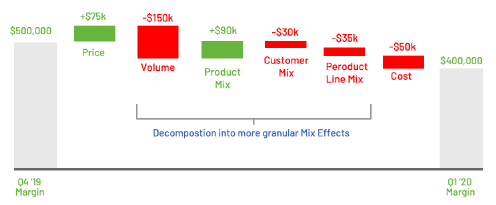

It's a Swiss-army-knife analytical tool to answer questions such as:
* (A multi-national FMCG) How much is price pressure comtributing to the profitability decline vs. budget?
* (Any labor intensive business) How much of the labour cost increase in 2023 is due to salaries vs. additional headcount?
* (A retailer) How much of the average price decline is due to changing product composition?
* (Manufacturing) How much of the gross margin increase last year can be attributed to production yield improvements?
* (A B2C SaaS) What were the key drivers behind retention rate decline in Q3?

In other words, it's all about isolating price (or cost) vs. volume impact on a metric that depends on both of them. While mostly employed in industries where pricing, unit costs and product selection is key (retail, manufacturing), there are use cases in any business that reaches a certain level of complexity and where there are competing "rate" vs. "quantity" dynamics. In a telecom operator (or any subscription business) that's users vs. their average spend, in a consulting business that's # of hours billed vs. hourly rate (vs. labor cost), in any global company it's earnings in their local currency vs. average FX rate ("constant currency" analysis is just a version of PVM). 

In other words, it's super useful. However, glance at resources on the web and you will likely see different formulas, get confused by what exactly "Mix effect" is and struggle to get beyond the basics. I spent 10+ years working in EY's Transaction Advisory (a.k.a. "Strategy and Transactions" today) analysing financial performance of companies and PVM was a frequent tool of choice. But even within EY, we had varying methodologies, terminologies, and other -logies; I happen to be the person who led a development of an internal "handbook for PVM analysis" that tried to provide some common ground for unifying approaches used across the firm, so I dare say I know a few things about the topic. I figured that it may be worth to write (a few) blog posts about it. Besides, I have been scarred by doing PVM analysis in monster Excel workbooks, nasty Alteryx workflows (and even nastier PowerBI implementations), and I wanted to see if I could write up a small Python package as I go along.



## Data at hand

In this blog post, I will be using [a dataset from Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce), a Brazilian e-commerce company. It works as a platform e-marketplace, connecting businesses with consumers. You can think about it as Etsy or Amazon, just without the any own products or inventory. The dataset contains real commercial data (anonymized), down to an order level - exactly the type of situation where PVM analysis can be very handy. For each order, we know the customer, the seller, and the products in the order, plus price and date information; products roll up to categories, while both customers and sellers have associated geographical information.

Let's imagine we are interested in understanding how the company was doing in years 2017-2018. We can grab the dataset and do some basic aggregations.

In [2]:
totals = (
    sales_data.group_by(["year"])
    .agg(
        pl.sum("revenue").alias("Total revenue ('000)") / 1000,
        pl.sum("quantity").alias("Total products sold ('000)") / 1000,
    )
    .with_columns(
        (pl.col("Total revenue ('000)") / pl.col("Total products sold ('000)")).alias(
            "Average price"
        )
    )
    .melt(id_vars="year", variable_name="KPI")
    .pivot(index="KPI", values="value", columns="year")
    .with_columns(
        (pl.col("2018") - pl.col("2017")).alias("change"),
        ((pl.col("2018") - pl.col("2017")) / pl.col("2017") * 100).alias("% change"),
    )
)


def print_table(df: pl.DataFrame, round=1):
    print(
        tabulate.tabulate(
            df.to_pandas().round(round),
            headers=df.columns,
            tablefmt="pretty",
            showindex=False,
        )
    )


print_table(totals)

+----------------------------+--------+--------+--------+----------+
|            KPI             |  2017  |  2018  | change | % change |
+----------------------------+--------+--------+--------+----------+
|    Total revenue ('000)    | 6805.5 | 8364.3 | 1558.8 |   22.9   |
| Total products sold ('000) |  48.7  |  59.6  |  11.0  |   22.5   |
|       Average price        | 139.8  | 140.2  |  0.4   |   0.3    |
+----------------------------+--------+--------+--------+----------+


Looks like Olist was doing great - its revenue was up 1.6M (23%), mostly because it sold more products (though average price also went up a bit).

## Understanding PVM decomposition

PVM, fundamentally, is all about very simple formulas to decompose a change. Suppose we wanted to produce a break down the 1.6M revenue increase and be able to say how much of it was "due to volume" and how much was "due to price". It's clear that the majority of the impact is due to volume - but can we put a number to it?

<img src="img/kirkby-1970.png" alt="Kirkby's publication on variance calculations" style="width: 200px;"/>

Well, already back in [1970s](https://egrove.olemiss.edu/mgmtservices/vol7/iss2/7/), people figured out that the easiest way is to do it by holding the other factor constant:

* Price impact = [Change in price] * Quantity
* Quantity impact = [Change in Quantity] * Price

Unfortunately, when both prices & quantities change at the same time, application of above formulas doesn't add up to total change in revenue. I find it easiest to illustrate it geometrically, where we can think of revenue represented by the area of a rectangle, with price/quantity representing the two axes.
 
<img src="img/geometric-pvm-illustration.png" alt="Geometric PVM illustration" style="width: 550px;"/>

So what do we do with that pesky $(\text{Price}_2 - \text{Price}_1) * (\text{Quantity}_2 - \text{Quantity}_1)$ component? There are several approaches. One of them is completely wrong: to call it a mix effect. Unfortunately, it's not uncommon to see exactly that. It has nothing to do with true mix effect (that we'll get to eventually). Never do that. As for "valid alternatives":

* Most commonly, the component is folded into either of the two effects, by slighly modifiying the formula. Typically, it's the price effect that gets updated to be $(\text{Price}_2 - \text{Price}_1) * \text{Quantity}_2$. You can think about it as an implicit assumption that the business is price-driven, and so any "joint" effects are primarily attributable to price changes.
* I've seen analyses that present this component separately. It's a rare approach - primarily because its interpretation is not straightforward, and you don't want to spend 15min explaining what it means to the CEO every time. It's also not very intuitive; e.g. if prices and volumes both decline, this component is positive. While it makes sense once you ponder about it, again, it creates more trouble than it may be worth.
* Some teams in EY used an approach where the component was allocated to price or volume effect depending on whether volumes were going up or down. The precise formulas were $\text{Price effect} = (\text{Price}_2 - \text{Price}_1) * Min(\text{Quantity}_1, \text{Quantity}_2)$ and $\text{Volume effect} = (\text{Quantity}_2 - \text{Quantity}_1) * \text{Price}_{argmin(\text{Quantity}_1, \text{Quantity}_2)}$ I've never seen an satisfying reasoning for it ¯\\_(ツ)_/¯. I _think_ it tries to make effects more "symmetric" or perhaps(?) account for price elasticity - if it's the former, I don't think it's a valid mathematical reason, and if it's the latter, I don't think it works properly either. Perhaps one day I'll write short exploration of it separately.

For the rest of the post, we'll go with the most common approach:
$$
\text{Price effect} = (\text{Price}_2 - \text{Price}_1) * \text{Quantity}_2 \\ 
\text{Volume effect} = (\text{Quantity}_2 - \text{Quantity}_1) * \text{Price}_1
$$

Final caveat: in case data does not exist in either of the periods (e.g. you're calculating effects for a newly launched or discontinued product), the full effect, of course, is of volume in nature. In practice, formulas thus should contain an extra "if" clause to capture it:

$$
\text{Price effect} = 
\left\{ 
    \begin{array}{ c l }
    (\text{P}_2 - \text{P}_1) * \text{Q}_2 & \quad \textrm{if } \text{Q}_2 \ge 0 \text{ and } \text{Q}_1 \ge 0 \\
    0 & \quad \textrm{otherwise}
  \end{array}
\right.
$$

$$
\text{Volume effect} = 
\left\{ 
    \begin{array}{ c l }
    (\text{Q}_2 - \text{Q}_1) * \text{P}_1 & \quad \textrm{if } \text{Q}_2 \ge 0 \text{ and } \text{Q}_1 \ge 0 \\
    \text{Q}_2 * \text{P}_2 - \text{Q}_1 * \text{P}_1 & \quad \textrm{otherwise}
  \end{array}
\right.
$$


Let's now apply it on our summarized dataset:

In [3]:
pandas_totals = totals.to_pandas().set_index("KPI")

p2017 = pandas_totals.loc["Average price", "2017"]
p2018 = pandas_totals.loc["Average price", "2018"]
q2017 = pandas_totals.loc["Total products sold ('000)", "2017"]
q2018 = pandas_totals.loc["Total products sold ('000)", "2018"]
r2017 = pandas_totals.loc["Total revenue ('000)", "2017"]
r2018 = pandas_totals.loc["Total revenue ('000)", "2018"]

price_effect = (p2018 - p2017) * q2018
volume_effect = (q2018 - q2017) * p2017

print(f"Price effect: {price_effect:.2f}")
print(f"Volume effect: {volume_effect:.2f}")
print(f"Total change: {price_effect + volume_effect:.2f}")
print(
    f"Total effect is equal to revenue change: {np.isclose(price_effect + volume_effect, r2018 - r2017)}"
)
print(
    f"Price effect as % of total change: {price_effect/(price_effect + volume_effect):.2f}"
)

Price effect: 25.20
Volume effect: 1533.58
Total change: 1558.78
Total effect is equal to revenue change: True
Price effect as % of total change: 0.02


Great, so we've quantified that (average) price changes only contributed to 25k (2% of overall change) increase in Olist revenue. We can even put it on a fancy waterfall chart.

In [4]:
pmv_charts.waterfall(
    [
        ("2017", True, r2017),
        ("Price effect", False, price_effect),
        ("Volume effect", False, volume_effect),
        ("2018", True, 0),
    ]
).properties(width=500, title="Olist revenue bridge 2017-2018")

alt.LayerChart(...)

This, of course, is not really useful. You don't really need price-volume analysis for above. Where PVM shines, however, is when you want to go a bit deeper. Suppose that our executive team is interested in understanding how different geographical areas are performing - and whether some specific states are under price pressure due to some local competitors.

Let's first have a look at data to get a sense on how company performance looks like when broken down by geography. We can, for example, visualize the % changes in average price, volume and revenue by state.


In [5]:
totals_by_state = (
    sales_data.group_by(["year", "customer_state"])
    .agg(
        pl.sum("revenue").alias("Total revenue ('000)") / 1000,
        pl.sum("quantity").alias("Total products sold ('000)") / 1000,
    )
    .with_columns(
        (pl.col("Total revenue ('000)") / pl.col("Total products sold ('000)")).alias(
            "Average price"
        )
    )
    .melt(id_vars=["year", "customer_state"], variable_name="KPI")
    .pivot(index=["customer_state", "KPI"], values="value", columns=["year"])
    .with_columns(
        (pl.col("2018") - pl.col("2017")).alias("change"),
        ((pl.col("2018") - pl.col("2017")) / pl.col("2017") * 100).alias("% change"),
    )
)

alt.Chart(totals_by_state).mark_bar().encode(
    alt.X("customer_state", axis=alt.Axis(labelAngle=0)),
    y="% change",
    row="KPI",
    tooltip=alt.Tooltip("% change"),
    color=alt.condition(
        alt.datum["% change"] < 0, alt.ColorValue("red"), alt.ColorValue("green")
    ),
).properties(width=550, height=100).resolve_scale(y="independent")

alt.Chart(...)

What we see is that performance indeed varies by geography. There are some states where prices have decreased, and we also see that largest % revenue increase is from RR, which I assume represents [Roraima](https://en.wikipedia.org/wiki/Roraima) - the least populous state in Brazil thats situated in the Amazon rainforest and accounts for just 0.2% of Brazil's GDP. That's not an expected place for growth - and indeed, if we were to display absolute changes instead, we would see that the % changes were deceiving. 

From an absolute perspective, the dominant state is SP (Sao Paolo). But it's hard to assess what exactly is happening with prices - the 1.6x increase in Roraima is throwing comparisons off.

In [6]:
alt.Chart(totals_by_state).mark_bar().encode(
    alt.X("customer_state", axis=alt.Axis(labelAngle=0)),
    y="change",
    row="KPI",
    tooltip=alt.Tooltip("change"),
    color=alt.condition(
        alt.datum["change"] < 0, alt.ColorValue("red"), alt.ColorValue("green")
    ),
).properties(width=550, height=100).resolve_scale(y="independent")

alt.Chart(...)

Here's where PVM decomposition comes in. The nice property of PVM analysis is that it's additive. We can do the calculations on a state level, aggregate them, and still arrive at total revenue change. Let's do that.

In [7]:
# produce a dataset by year & state
kpis_by_year_and_state = (
    sales_data.group_by(["year", "customer_state"])
    .agg(
        pl.sum("revenue").alias("Total revenue ('000)") / 1000,
        pl.sum("quantity").alias("Total products sold ('000)") / 1000,
    )
    .with_columns(
        (pl.col("Total revenue ('000)") / pl.col("Total products sold ('000)")).alias(
            "Average price"
        ),
        (pl.col("year") + 1).alias("next_year"),
    )
)

# join 2017 data with 2018 data, so we have both years side-to-side
joined = kpis_by_year_and_state.filter(pl.col("year") == 2017).join(
    kpis_by_year_and_state.filter(pl.col("year") == 2018),
    left_on=["customer_state", "next_year"],
    right_on=["customer_state", "year"],
    suffix="_next",
    how="outer",
)

# apply formulas
effects = (
    joined.with_columns(
        (
            (pl.col("Average price_next") - pl.col("Average price"))
            * pl.col("Total products sold ('000)_next")
        ).alias("price_effect"),
        (
            (
                pl.col("Total products sold ('000)_next")
                - pl.col("Total products sold ('000)")
            )
            * pl.col("Average price")
        ).alias("volume_effect"),
    )
    .select(["customer_state", "price_effect", "volume_effect"])
    .sort("customer_state")
    .with_columns(
        (pl.col("price_effect") + pl.col("volume_effect")).alias("total_effect")
    )
)


print_table(effects)

print_table(effects.sum())

+----------------+--------------+---------------+--------------+
| customer_state | price_effect | volume_effect | total_effect |
+----------------+--------------+---------------+--------------+
|       AC       |     -0.5     |     -5.6      |     -6.1     |
|       AL       |     -6.2     |     -1.4      |     -7.6     |
|       AM       |     1.1      |      1.4      |     2.6      |
|       AP       |     0.8      |      0.9      |     1.7      |
|       BA       |     21.5     |     29.6      |     51.1     |
|       CE       |     -2.4     |      1.1      |     -1.2     |
|       DF       |     -5.4     |     47.2      |     41.8     |
|       ES       |     26.6     |     14.9      |     41.5     |
|       GO       |     4.7      |     16.4      |     21.1     |
|       MA       |     4.1      |     -2.5      |     1.6      |
|       MG       |     42.6     |     123.0     |    165.7     |
|       MS       |    -11.5     |     26.1      |     14.5     |
|       MT       |    -10

Everything adds up - the total effect is still `1558.8k`, equal to the total revenue change. The split, however, has changed - our previous analysis had price effect at `25k` and volume effect at `1.533M`, but now we got `123k` and `1436k`. Which one is right? 

The answer is the **M** part of PV**M**. By calculating effects on a state level, our price effect is no longer affected by changing volume mix of the states. Given that now we got a larger price effect (`123k` vs. `25k` previously), it implies that the mix effect itself must be negative (`-98k`). In other words, the volume in low-priced states must have gone up more than in high-priced states. Let's see if we can confirm that visually. 


In [8]:
reference_price_and_volume = (
    totals_by_state.filter(pl.col("KPI") == "Total products sold ('000)")
    .select(
        pl.col("customer_state"),
        pl.col("% change").alias("volume_change, %"),
        pl.col("2017").alias("Volume 2017"),
    )
    .join(
        totals_by_state.filter(pl.col("KPI") == "Average price").select(
            pl.col("customer_state"), pl.col("2017").alias("2017 price")
        ),
        on="customer_state",
    )
)
c = alt.Chart(reference_price_and_volume).encode(
    alt.X("2017 price"),
    alt.Y("volume_change, %"),
    alt.Color("customer_state", legend=None),
    alt.Tooltip("customer_state"),
    alt.Text("customer_state"),
)

c.mark_point().encode(
    alt.Size("Volume 2017", legend=None),
) + c.mark_text(size=8)

alt.LayerChart(...)

From the above chart, it's pretty clear that it's what happened. Sao Paolo, in particular, is a low-priced state that had highest volume growth. More broadly, you can see a near perfectly linear relationship between change in volume and average price in the state - something the executive team could ponder about.

With all this data, now we can put together an even better chart that summarizes what is going on in the business. This part is more art than science - it's all about the storytelling. Here's one way we could do it.

In [9]:
top5_volume_effects = effects.sort(
    pl.col("volume_effect").abs(), descending=True
).to_dicts()[:5]
top5_price_effects = effects.sort(
    pl.col("price_effect").abs(), descending=True
).to_dicts()[:5]

In [10]:
state_volume_effect_total = effects["volume_effect"].sum()
state_price_effect_total = effects["price_effect"].sum()

chart_components = (
    [("2017", True, r2017)]
    + [
        (f"{state['customer_state']} volume effect", False, state["volume_effect"])
        for state in top5_volume_effects
    ]
    + [
        (
            "Other states - volume",
            False,
            state_volume_effect_total
            - sum([state["volume_effect"] for state in top5_volume_effects]),
        )
    ]
    + [
        (f"{state['customer_state']} price effect", False, state["price_effect"])
        for state in top5_price_effects
    ]
    + [
        (
            "Other states - price",
            False,
            state_price_effect_total
            - sum([state["price_effect"] for state in top5_price_effects]),
        )
    ]
    + [("2018", True, 0)]
)


pmv_charts.waterfall(chart_components, labelAngle=-60).properties(
    width=650, title="Olist revenue bridge 2017-2018"
)

alt.LayerChart(...)

# Explicit mix effect calculation

Some PVM materials discuss formulas that calculate mix impact explictly. Again, I am not referring to the ones that call the "joint price and volume" effect as mix impact. That's just blatantly wrong. The explicit formulas are OK - but I am not a fan of them, you can get the same result by computing price/volume effects on different granularity levels and then comparing the results. In the old days of huge Excel spreadsheets where making multiple calculations was difficult, explicit mix formulas made sense. They make less sense when you're equipped with something like Python.

Nevertheless, it's a good way to develop intuition for PVM extensions beyond just price and volume calculations. The idea is very much the same - we need to find two variables, where volume mix is one of them, and then apply similar formulas to calculate the impact. 

With revenue, the two components were price and volume, and we established that if we have $i$ calculation units (e.g. states), we can get to revenue as:
$$ \text{Revenue} = \sum_{i=1}^{N}{\text{price}_{i} * \text{volume}_{i}} $$

Instead of having volume directly in the formula, we could instead write it this way:

$$ \text{Revenue} = \sum_{i=1}^{N}{\text{price}_{i} * (\sum{\text{volume}_{i}}} * \frac{\text{volume}_{i}}{\sum{\text{volume}_{i}}} ) $$

It's like a high school math trick. We took volume in a particular state $i$ and divided and multiplied it by total volume across the business. Now, however, we can think about the formula as having three components: price, total volume, and "share of volume". And what is mix impact? You guessed it, it's a change in share of volumes!

Let's we can update our formulas, so that in each case only one of the components is changing:

$$
\text{Price effect} = (\text{Price}_2 - \text{Price}_1) * \text{Quantity}_2 \\ 
\text{Volume effect} = (\text{Total Quantity}_2 - \text{Total Quantity}_1) * \text{Share of Quantity}_1 * \text{Price}_1 \\
\text{Mix effect} = (\text{Share of Quantity}_2 - \text{Share of Quantity}_1) * \text{Total Quantity}_1 * \text{Price}_1
$$

If we were to use these formulas to calculate effects, we would get `123k` for price effect (formula hasn't changed), `1533k` for volume effect (same as if we were to calculate volume effect on an aggregated data) and `-98k` for mix effect (exactly what we got when we compared the two sets of calculations above).

Confusing? Yeah, I know... I made a [quick spreadsheet](https://docs.google.com/spreadsheets/d/1fDR5vNHIOO0MfBQPC69R9moflt5fR8MwWI2IpD0Wirs/edit?usp=sharing) with the above calculations - if you're really determined, you may want to check it out. Confusion isn't the only reason I am not a fan of these formulas. The other reason is that mix impact does not have a good meaning on a individual calculation unit level. Let's take Sao Paolo. Our analysis shows that the volume growth in it contributed `924k` in revenue. Using the 3-component formula, we get that `924k` is now broken down into `538k` in volume effect and `386k` in mix effect. But what does it mean? Also, we concluded that the overall mix effect was negative (`-98k`), and we know that Sao Paolo was the main reason for it - its growth brought our average prices down. How can its mix effect be positive? What is going on? 

The answer, in brief, is that mix effects by state are affecting each other. If share of volume of one state goes up, then, by definition, some other states will see their share decline. And that's why you can't really look at them separately. It's possible to wrap your head aroud their meaning - but the chances of communicating them effectively to a business person are really low. My advice is to avoid doing that. We'll return to a better way to look at mix impacts later on.








## Turtles all the way down

Now that we're clear with the mechanics behind PVM, let's turn to the the most important aspect of the analysis, which, if not chosen carefully, make the output of it, at a minimum, hard to interpret, and worst - complete rubbish. And it's not "which formula variation to use". Instead, the choice that's most important is the one of the unit of analysis.

So far, we did calculations on an aggregate level and on a customer-based geography level. But we have access to so many more dimensions in this data! We could analyse price and volume dynamics by:
* Seller geography or even individual seller
* Product category or even individual product
* Individual customer
* A combination of the above factors

What's the right choice? For one, it's not necessarily the most granular level possible. Suppose we calculated effects on individual customer ID / seller ID / product ID combination. In that case, we would only capture price effects in situations where the same customer bought the same product from the same seller. Everything else would count as volume effects. That doesn't sound very appropriate. In fact, in this particular dataset, not a single customer appears in multiple years (probably a function of anonymization), so it definitely would not work.

You could take a product-first perspective: it doesn't matter who buys it and from whom they buy it, price effects should capture pricing changes in individual products. This approach could be appropriate for a company that sells products that don't change often. E.g., your local bakery. You could calculate it PMV effects on every cookie, coffee and lunch item variation and the total price effects would likely represent price inflation. But in an e-commerce marketplace, a lot individual products are shortlived. If we were to do PVM analysis on a product ID level, we would get this:



In [11]:
defs = pvmf.TotalField(
    "revenue",
    "total",
    components=[
        pvmf.RateField(name="price"),
        pvmf.QuantityField("quantity"),
    ],
)

p = pvmc.PVM(
    sales_data.with_columns(pl.col("revenue") / 1000, pl.col("quantity") / 1000),
    period_col="year",
    calculation_fields=defs,
)
hierarchy = ["product_id"]

calculated = p.calculate(hierarchy=hierarchy, return_detail=True)

In [12]:
chart_components = itt.chain(
    [("2017", True, r2017)],
    p.find_largest_components(calculated, "product_id", max_components=0),
    [("2018", True, 0)],
)

pmv_charts.waterfall(chart_components, labelAngle=-60).properties(
    width=650, title="Olist revenue bridge 2017-2018"
)

alt.LayerChart(...)

In [13]:
print_table(p.summarize(calculated))

+---------------+---------------+---------+--------------+----------------+-----------------+--------------+--------------+-------+
|    status     | status_reason | revenue | revenue_next | revenue_change | quantity_effect | price_effect | total_effect | count |
+---------------+---------------+---------+--------------+----------------+-----------------+--------------+--------------+-------+
| like-for-like |               | 3092.5  |    3312.4    |     219.9      |      288.2      |    -114.4    |    173.8     | 4854  |
| discontinued  |  product_id   | 3713.0  |     0.0      |    -3713.0     |     -3713.0     |     0.0      |   -3713.0    | 11569 |
|  introduced   |  product_id   |   0.0   |    5051.9    |     5051.9     |     5051.9      |     0.0      |    5051.9    | 15063 |
+---------------+---------------+---------+--------------+----------------+-----------------+--------------+--------------+-------+


Now, it could be that that's the story you want to tell: we're seeing a large product churn in the business, while the products that stay on the marketplace saw a volume increase, offset by lower prices. However, given that products that stay year-on-year account for less than 50% of total revenue, it may not be a good choice. There's a good chance that the relatively high negative price we're seeing is because of substitution effects: newly introduced products are effectively replacements for existing products, and the latter are then sold at lower prices to clear the inventory. 

Imagine we were selling phones - when iPhone 20 is released, the price of iPhone 19 will typically go down. But should this be reflected as a "price effect"? That's just product portfolio change. In this case, we may be more interested in capturing price changes across the entire phone SKU portfolio, acknowledging that price effects will be a function of deliberate pricing changes as well as the change in the mix of phone SKU portfolio. 

Unfortunately, the dataset does not have categorization of products on that level of detail. Instead, we only have broad categories. Let's see what happens if we use those. 

In [58]:
imp.reload(pmv_charts)
hierarchy = ["product_category_name_english"]

calculated = p.calculate(hierarchy=hierarchy, return_detail=False)

chart_components = list(
    itt.chain(
        [("2017", True, r2017)],
        p.find_largest_components(calculated, hierarchy[0], max_components=5),
        [("2018", True, 0)],
    )
)

pmv_charts.waterfall(chart_components, labelAngle=-60).properties(
    width=650, title="Olist revenue bridge 2017-2018"
)

alt.LayerChart(...)

In [59]:
print_table(p.summarize(calculated))

+---------------+-------------------------------+---------+-----------------+--------------+--------------+-------+
|    status     |         status_reason         | revenue | quantity_effect | price_effect | total_effect | count |
+---------------+-------------------------------+---------+-----------------+--------------+--------------+-------+
| like-for-like |                               | 6805.2  |     1465.2      |    -184.5    |    1280.8    |  70   |
| discontinued  | product_category_name_english |   0.3   |      -0.3       |     0.0      |     -0.3     |   1   |
+---------------+-------------------------------+---------+-----------------+--------------+--------------+-------+


Now we are starting to see some interesting dynamics. First of all, price effect is highly negative (-185M), and it appears that there are two specific product categories - computer accessories & watches - where price decreases are concentrated. Given our unit of analysis, it could represent a shift of mix towards lower-priced product subcategories (e.g. more keyboard sales than monitor sales), but it nevertheless is an interesting dynamic. We can also see which product categories account for the majority of the volume growth: watches, health & beauty, computer accessories and auto are the main drivers.

A completely different perspective would be to argue that Olist is primarily about sellers. We should thus analyse its growth first by understanding if we are gaining/losing sellers and what happens to their sales. In fact, we could combine both seller- and product- perspectives.

In [64]:
imp.reload(pmv_charts)
hierarchy = ["seller_id", "product_category_name_english"]

calculated = p.calculate(hierarchy=hierarchy, return_detail=False)

chart_components = list(
    itt.chain(
        [("2017", True, r2017)],
        p.find_largest_components(calculated, hierarchy[1], max_components=5),
        [("2018", True, 0)],
    )
)

pmv_charts.waterfall(chart_components, labelAngle=-60).properties(
    width=650, title="Olist revenue bridge 2017-2018"
)

alt.LayerChart(...)

In [65]:
print_table(p.summarize(calculated))

+---------------+-----------------------------------------+---------+-----------------+--------------+--------------+-------+
|    status     |              status_reason              | revenue | quantity_effect | price_effect | total_effect | count |
+---------------+-----------------------------------------+---------+-----------------+--------------+--------------+-------+
|  introduced   | seller_id,product_category_name_english |   0.0   |      449.7      |     0.0      |    449.7     |  725  |
|  introduced   |                seller_id                |   0.0   |     2458.2      |     0.0      |    2458.2    | 2151  |
| discontinued  |                seller_id                |  698.2  |     -698.2      |     0.0      |    -698.2    |  852  |
| discontinued  | seller_id,product_category_name_english |  308.4  |     -308.4      |     0.0      |    -308.4    |  604  |
| like-for-like |                                         | 5799.0  |     -261.3      |    -98.4     |    -359.8    | 

The chart labels that my WIP package spits out are imperfect, so let's take it step by step:

 * The biggest driver to revenue increase, it turns out, are sellers. New sellers contributed +2.458M in sales, offset by 698k lost sales from sellers that stopped using the platform.
 * Additionally, existing sellers saw a net positive effect from changes in the breadth of their portfolios. New product categories entered by existing sellers contributed 449k, offset by 308k of "category exits". 
 * The price and volume effects among existing sellers selling in existing product categories were, overall, quite limited in coparison to seller-driven effects. Additionally, turns out both of them were negative: total volume effect among these items was -261k, and price effect -98k. Watches & gifts, a category that seemed to be of high-growth before, now shows up as with highest negative volume effects!

It may seem that PVM analysis gives contradicting results every time. But what really is happening is that our chosen unit of analysis allows getting a different perspective into what's happening in Olist. If you were to sit back and think what kind of big picture all these analyses tell you, you could conclude something like this:
* Revenue growth in Olist was primarily driven by influx of new sellers;
* New sellers cannibalized existing sellers' sales - leading to volume decreases - and forcing sellers to lower prices in order to be able to compete.



In [70]:
imp.reload(pmv_charts)
hierarchy = ["product_category_name_english", "seller_id",  "product_id",]

calculated = p.calculate(hierarchy=hierarchy, return_detail=False)

chart_components = list(
    itt.chain(
        [("2017", True, r2017)],
        p.find_largest_components(calculated, hierarchy[0], max_components=5),
        [("2018", True, 0)],
    )
)

pmv_charts.waterfall(chart_components, labelAngle=-60).properties(
    width=650, title="Olist revenue bridge 2017-2018"
)

alt.LayerChart(...)

In [71]:
print_table(p.summarize(calculated))

+---------------+----------------------------------------------------+---------+-----------------+--------------+--------------+-------+
|    status     |                   status_reason                    | revenue | quantity_effect | price_effect | total_effect | count |
+---------------+----------------------------------------------------+---------+-----------------+--------------+--------------+-------+
| discontinued  | product_category_name_english,seller_id,product_id | 2929.3  |     -2929.3     |     0.0      |   -2929.3    | 9291  |
|  introduced   |      product_category_name_english,seller_id       |   0.0   |     2908.0      |     0.0      |    2908.0    | 7527  |
|  introduced   | product_category_name_english,seller_id,product_id |   0.0   |     2575.1      |     0.0      |    2575.1    | 8605  |
| discontinued  |           product_category_name_english            |   0.3   |      -0.3       |     0.0      |     -0.3     |   2   |
| discontinued  |      product_category_n

## Zooming in

Let's take one particular product category - Watches & gifts and look a bit closer.

In [62]:
calculated.filter(pl.col("product_category_name_english") == "watches_gifts").select(cs.contains('effect'))

quantity_effect,price_effect,total_effect
f64,f64,f64
299.20548,-86.96099,212.24449


In [52]:
hierarchy = ["product_category_name_english", "product_id"]

watches = p.calculate(hierarchy=hierarchy, return_detail=True).filter(pl.col("product_category_name_english") == "watches_gifts")

watches_2017 = watches.select(pl.col('revenue').sum()).item()
chart_components = list(
    itt.chain(
        [("2017", True, watches_2017)],
        p.find_largest_components(watches, hierarchy[1], max_components=0),
        [("2018", True, 0)],
    )
)

pmv_charts.waterfall(chart_components, labelAngle=-60).properties(
    width=650, title="Olist revenue bridge 2017-2018"
)

alt.LayerChart(...)

In [56]:
watches.group_by('status').agg(pl.col('quantity').sum(), pl.col('revenue').sum(), pl.col('quantity_next').sum(), pl.col('revenue_next').sum()).with_columns(
    (pl.col('revenue') / pl.col('quantity')).alias("avg_price"),
    (pl.col('revenue_next') / pl.col('quantity_next')).alias("avg_price_next")
)

status,quantity,revenue,quantity_next,revenue_next,avg_price,avg_price_next
str,f64,f64,f64,f64,f64,f64
"""introduced""",0.0,0.0,1.108,352.18992,NaN,317.860939
"""discontinued""",0.739,254.58132,0.0,0.0,344.494344,NaN
"""like-for-like""",1.488,257.21965,2.52,397.54852,172.862668,157.757349


In [53]:
print_table(p.summarize(watches))

+---------------+------------------------------------------+---------+--------------+----------------+-----------------+--------------+--------------+-------+
|    status     |              status_reason               | revenue | revenue_next | revenue_change | quantity_effect | price_effect | total_effect | count |
+---------------+------------------------------------------+---------+--------------+----------------+-----------------+--------------+--------------+-------+
| discontinued  | product_category_name_english,product_id |  254.6  |     0.0      |     -254.6     |     -254.6      |     0.0      |    -254.6    |  460  |
| like-for-like |                                          |  257.2  |    397.5     |     140.3      |      199.6      |    -75.4     |    124.2     |  264  |
|  introduced   | product_category_name_english,product_id |   0.0   |    352.2     |     352.2      |      352.2      |     0.0      |    352.2     |  573  |
+---------------+-----------------------------